# Load Libraries

In [1]:
# plotting
import matplotlib.pyplot as plt

# manipulate data
import pandas as pd

# more plotting
import seaborn as sns

# make pandas types compatibile with matplotlibs
pd.plotting.register_matplotlib_converters()

# create a dictionary to unpack to update plotly plots settings
# why can't it be as easy as with ggplot...
plotly_dict = dict(
    font_family="Yanone Kaffeesatz",
    template="none",
    title={"x": 0.05, "xanchor": "left"},
)

sns_dict = {
    "axes.facecolor": "1",
    "grid.color": "0.9",
    "font.family": ["sans-serif"],
    "font.sans-serif": ["Yanone Kaffeesatz", "DejaVu Sans"],
}

sns.set_style(style="whitegrid", rc=sns_dict)
sns.set_palette(palette="deep")
%matplotlib inline

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

# Keyword: Euro 

## Load Data

In [18]:
def clean_colnames(dataf: pd.DataFrame) -> pd.DataFrame:

    dataf.columns = dataf.columns.str.replace(" ", "_").str.lower()

    return dataf

data_path = "../02-data/"

monthly_data = (
    pd.read_csv(data_path + "gtrends-monthly-all.csv", index_col=[0], parse_dates=[0])
     .drop(["mario_draghi", "christine_lagarde"], axis=1)
)

euro_daily_pytrends = (
    pd.read_csv(data_path + "pytrends-daily-euro.csv", index_col=[0], parse_dates=[0])
    # one way to apply a function with no args in rename()
    .rename(columns=str.lower)
    .drop("ispartial", axis=1)
)

ecb_daily_pytrends = (
    pd.read_csv(data_path + "pytrends-daily-ecb.csv", index_col=[0], parse_dates=[0])
    # rename with custom function
    .pipe(clean_colnames)
    .drop("ispartial", axis=1)
)

<AxesSubplot:xlabel='date'>

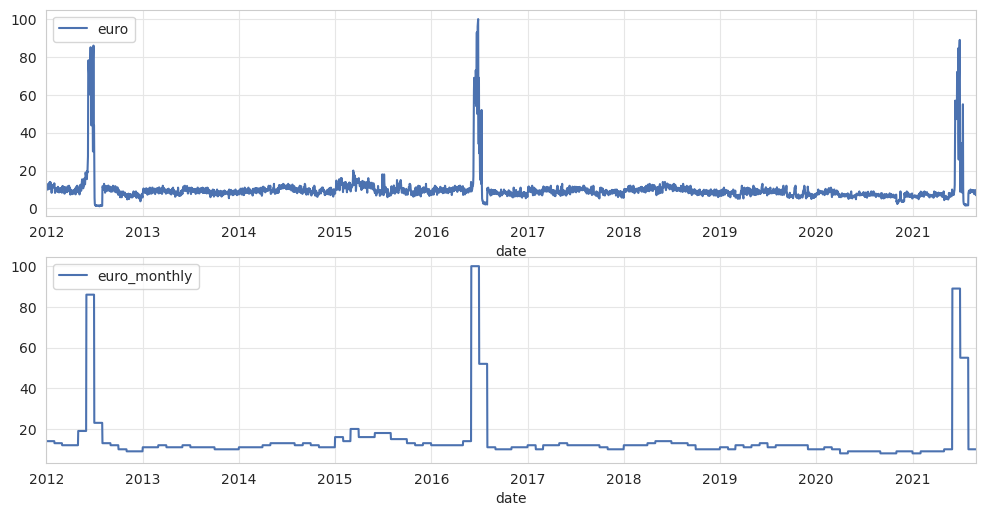

In [23]:
fig, ax = plt.subplots(2,1)

euro_daily_pytrends.plot(y="euro", ax=ax[0])
euro_daily_pytrends.plot(y="euro_monthly", ax=ax[1])



# Keyword: Mario Draghi

## Load Data

In [2]:
draghi_daily_2020_pytrends = pd.read_csv(
    "../02-data/exploration/daily-mario_draghi-pytrends-until_2020.csv",
    index_col=[0],
    parse_dates=[0],
)
draghi_daily_2020_overlap = pd.read_csv(
    "../02-data/exploration/daily-mario_draghi-overlap-until_2020.csv",
    index_col=[0],
    parse_dates=[0],
)
draghi_monthly_2020 = pd.read_csv(
    "../02-data/exploration/monthly-mario_draghi-until_2020.csv",
    index_col=[0],
    parse_dates=[0],
)

## Daily Data Comparison

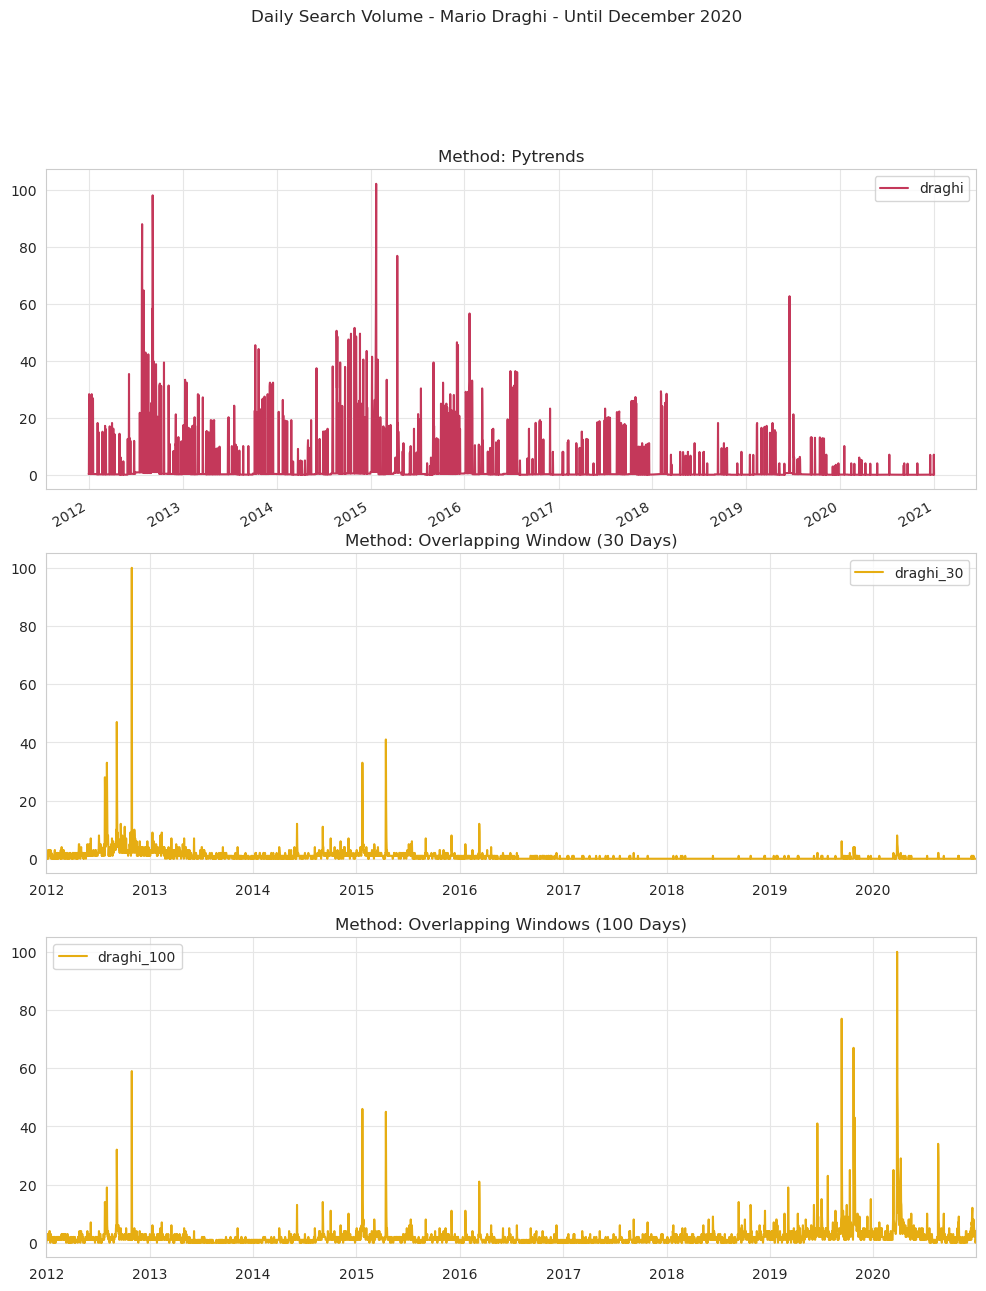

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(12, 16))

draghi_daily_2020_pytrends.plot(
    y=["draghi"],
    kind="line",
    title="Method: Pytrends",
    ax=ax[0],
    xlabel="",
    c=sns.color_palette("CMRmap")[2],
)
draghi_daily_2020_overlap.plot(
    y=["draghi_30"],
    kind="line",
    title="Method: Overlapping Window (30 Days)",
    ax=ax[1],
    xlabel="",
    c=sns.color_palette("CMRmap")[4],
)
draghi_daily_2020_overlap.plot(
    y=["draghi_100"],
    kind="line",
    title="Method: Overlapping Windows (100 Days)",
    ax=ax[2],
    xlabel="",
    c=sns.color_palette("CMRmap")[4],
)

plt.suptitle("Daily Search Volume - Mario Draghi - Until December 2020")

plt.show()

fig.savefig("../03-figures/retrieved_daily_data-mario_draghi.png")
fig.savefig("../03-figures/retrieved_daily_data-mario_draghi.jpeg")

## Resampling to Monthly Frequency

Now we resample this data to monthly and compare it with the official monthly data. To do so, we will use the `apply` method in pandas:

```python
s.apply(subtract_custom_value, args=(5,))
```

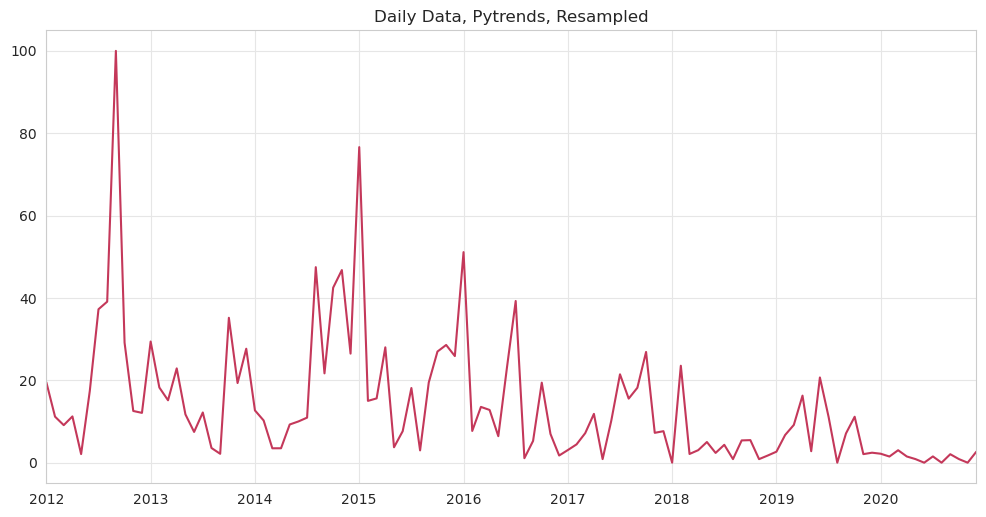

In [8]:
def scale(x: float, max_of: pd.DataFrame, freq: str = "MS") -> float:

    max_x = max_of.resample(freq).sum().max()

    return x / max_x * 100


fig, ax = plt.subplots(1, 1)

(
    draghi_daily_2020_pytrends["draghi"]
    .resample("MS")
    .sum()
    .apply(scale, args=(draghi_daily_2020_pytrends["draghi"],))
    .plot(
        title="Daily Data, Pytrends, Resampled",
        ax=ax,
        xlabel="",
        c=sns.color_palette("CMRmap")[2],
    )
)

plt.plot()

In [5]:
(
    draghi_daily_2020_pytrends["draghi"] / draghi_daily_2020_pytrends["draghi"].max()
).max()

1.0

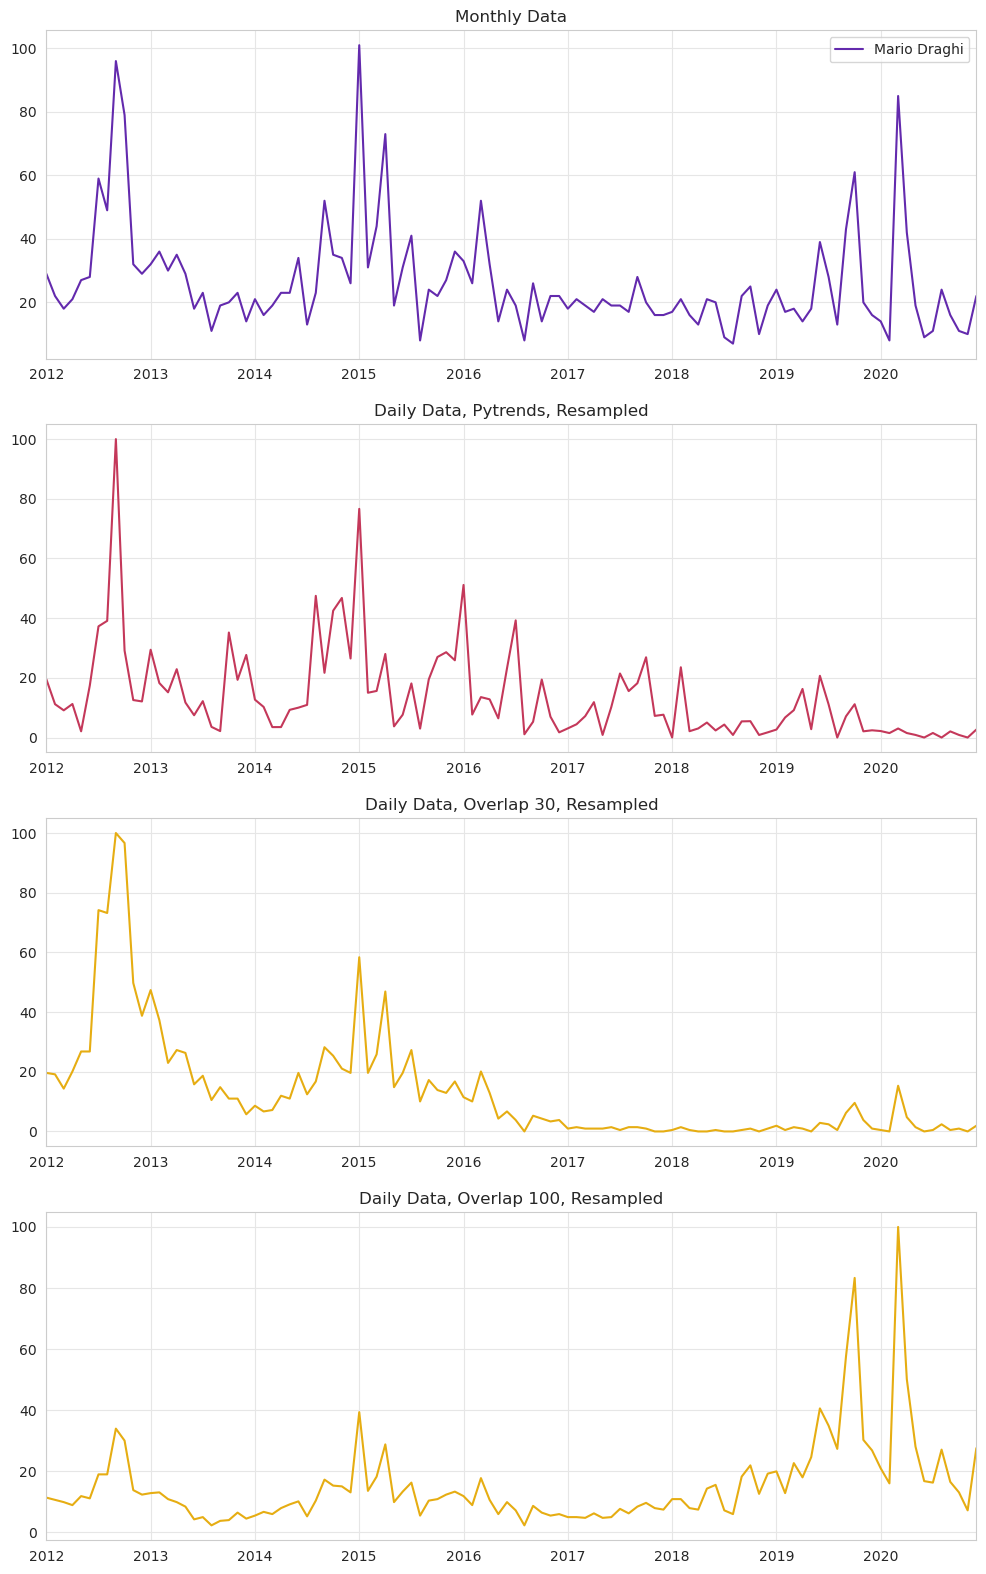

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(12, 20))

# monthly data from google trends
(
    draghi_monthly_2020.plot(
        y="Mario Draghi",
        title="Monthly Data",
        ax=ax[0],
        xlabel="",
        c=sns.color_palette("CMRmap")[1],
    )
)

# pytrends data
(
    draghi_daily_2020_pytrends["draghi"]
    .resample("MS")
    .sum()
    .apply(scale, args=(draghi_daily_2020_pytrends["draghi"],))
    .plot(
        title="Daily Data, Pytrends, Resampled",
        ax=ax[1],
        xlabel="",
        c=sns.color_palette("CMRmap")[2],
    )
)

# overlap 30
(
    draghi_daily_2020_overlap["draghi_30"]
    .resample("MS")
    .sum()
    .apply(scale, args=(draghi_daily_2020_overlap["draghi_30"],))
    .plot(
        title="Daily Data, Overlap 30, Resampled",
        ax=ax[2],
        xlabel="",
        c=sns.color_palette("CMRmap")[4],
    )
)

# overlap 100
(
    draghi_daily_2020_overlap["draghi_100"]
    .resample("MS")
    .sum()
    .apply(scale, args=(draghi_daily_2020_overlap["draghi_100"],))
    .plot(
        title="Daily Data, Overlap 100, Resampled",
        ax=ax[3],
        xlabel="",
        c=sns.color_palette("CMRmap")[4],
    )
)

plt.show()

fig.savefig("../03-figures/comparison_daily_data_methods-mario_draghi.png")
fig.savefig("../03-figures/comparison_daily_data_methods-mario_draghi.jpeg")

## Appendix and Tests

### Weekly Data

This is a bit more problematic: as it is retrieved in two pieces, we need to rescale them.

In [8]:
draghi_weekly_01 = pd.read_csv(
    "../02-data/python/gtrends-weekly-mario_draghi-01.csv",
    parse_dates=[0],
    index_col=[0],
    skiprows=2,
    squeeze=True,
).asfreq(freq="W")

draghi_weekly_02 = pd.read_csv(
    "../02-data/python/gtrends-weekly-mario_draghi-02.csv",
    parse_dates=[0],
    index_col=[0],
    skiprows=2,
    squeeze=True,
).asfreq(freq="W")

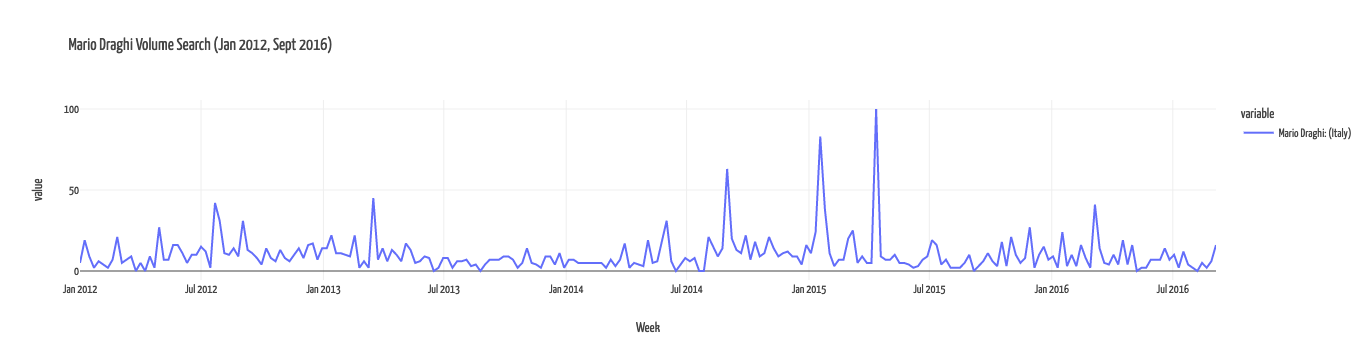

In [9]:
draghi_weekly_01.plot(
    title="Mario Draghi Volume Search (Jan 2012, Sept 2016)"
).update_layout(**plotly_dict)

The second data is of mixed types, we need to turn them into integers.

In [49]:
draghi_weekly_01 = draghi_weekly_01 + 1

draghi_weekly_02 = draghi_weekly_02.str.replace("<1", "0").astype("int") + 1

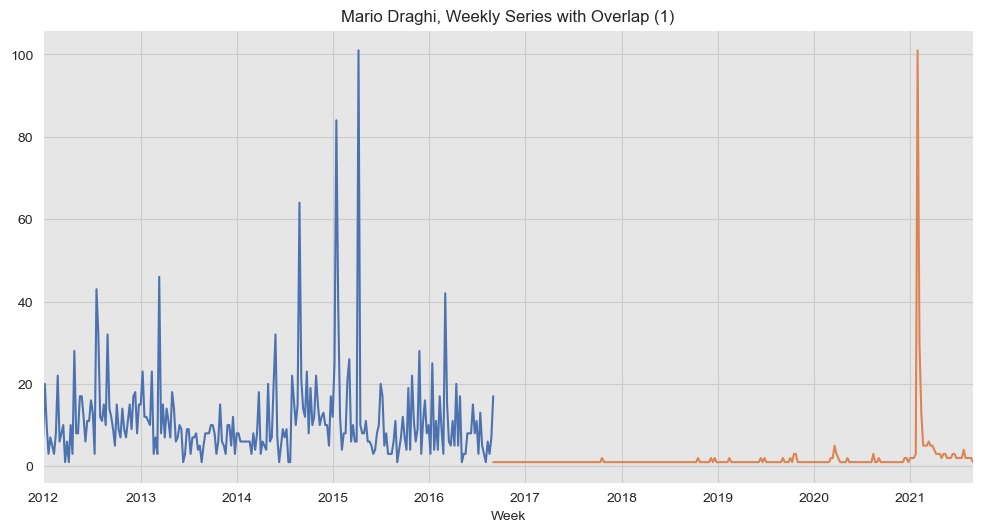

In [59]:
pd.options.plotting.backend = "matplotlib"

fig, ax = plt.subplots()

ax = draghi_weekly_01.plot()
ax = draghi_weekly_02.plot()

plt.title("Mario Draghi, Weekly Series with Overlap (1)")

plt.show()

### Monthly and Weekly Frequencies Comparison

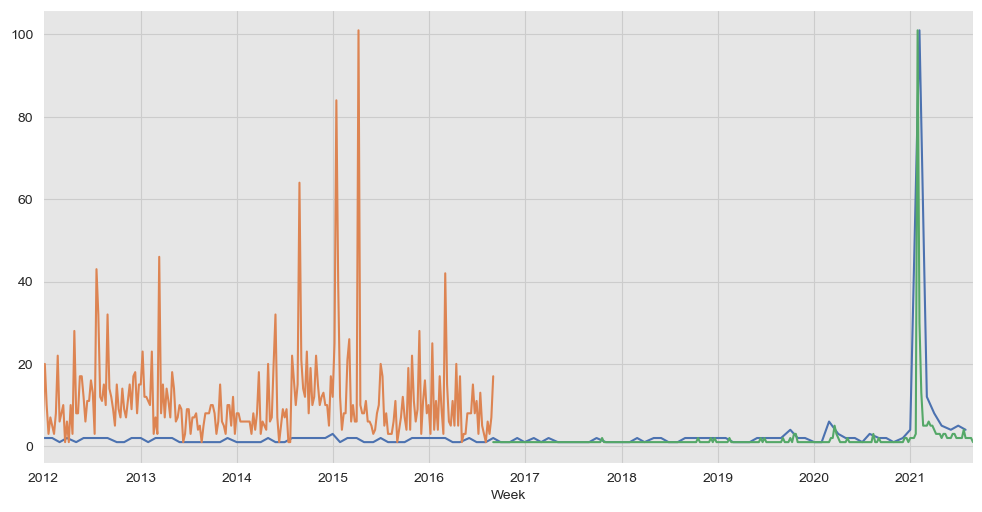

In [66]:
fig, ax = plt.subplots(1, 1)

ax = draghi_monthly.plot()
ax = draghi_weekly_01.plot()
ax = draghi_weekly_02.plot()